# Geoprocessing with GRASS GIS and Jupyter Notebooks

## GRASS GIS v8.4

- Geospatial Processing Engine
- Open Source (GPL v2)
- Developed by the GRASS Development Team
- GRASS GIS is a founding member of the Open Source Geospatial Foundation (OSGeo)

## Security First
- Recieved Open Source Security Foundation (OpenSSF) Best Practices Badge - 2024

## Modern Tooling

- Jupyter Notebooks
- GRASS GIS Python API
- Actinia REST API
- Easy intergration with other Data Science tools in Python and R ecosystem

## Community

- Active community of users and developers
- Mailing lists, chat, and forums
- Conferences and workshops
- Documentation and tutorials
- Mentoring and outreach programs



In [6]:
# import standard Python packages
import os
import sys
import subprocess
from pathlib import Path

In [7]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

In [8]:
# import GRASS GIS python packages
import grass.script as gs
import grass.jupyter as gj

In [9]:
# create a temporary folder where to place our GRASS project
import tempfile
tempdir = tempfile.TemporaryDirectory()

## Let's create a new project in GRASS for Chaco Canyon National Park.

The dataset is availeble through OpenTopography

### Data Collection

- Funding: National Science Foundation (NSF) Earth Sciences (EAR) Instrumentation and Facilities (IF) Program
- Partner: University of New Mexico
- Collector: National Center for Airborne Laser Mapping (NCALM)

**Data Characteristics**

- Area 542.72 km^2
- Over 13 Billion Points
- Point Density 25.56 pts/m^2

Raster Resolution 0.5 m


Coordinate System:
Horizontal: NAD83 (2011) (EPOCH:2010) / UTM Zone 13N Meters [EPSG: 6342]
Vertical: NAVD88 [EPSG: 5703]

Units: Meters

Complete metadata can be found at: [OpenTopography](https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.042019.6342.1)

> Dorshow, W. (2019).  3D Landscape Reconstruction and Land Use Modeling, Chaco Canyon, NM 2016. National Center for Airborne Laser Mapping (NCALM). Distributed by OpenTopography.  https://doi.org/10.5069/G9XG9P8D.. Accessed: 2024-08-19

In [10]:
gs.create_project(path=tempdir.name, name="ChacoCanyon2016", epsg="6342", overwrite=True)

In [11]:
# start GRASS in the recently created project
session = gj.init(Path(tempdir.name,"ChacoCanyon2016"))

## Download Add-ons

- t.stac.asset


- t.stac.items

## Select an Area of Interest to Use as the 

https://ot-process2.sdsc.edu/potree/index.html?r=%22https://ot-process2.sdsc.edu/appEntwineEPTService1724096588005642548939/pc1724096516919%22

In [15]:
!pdal info metadata/points.laz

{
  "file_size": 74356735,
  "filename": "metadata/points.laz",
  "now": "2024-08-19T15:53:59-0400",
  "pdal_version": "2.3.0 (git-version: Release)",
  "reader": "readers.las",
  "stats":
  {
    "bbox":
    {
      "EPSG:4326":
      {
        "bbox":
        {
          "maxx": -107.9511869,
          "maxy": 36.06548927,
          "maxz": 2518.38,
          "minx": -107.9647091,
          "miny": 36.05562793,
          "minz": 1858.61
        },
        "boundary": { "type": "Polygon", "coordinates": [ [ [ -107.964351121320917, 36.055627934089316, 1858.610000000000127 ], [ -107.964709145275819, 36.06516407896342, 1858.610000000000127 ], [ -107.951543337800317, 36.065489268244946, 2518.380000000000109 ], [ -107.951186898132434, 36.055953010341163, 2518.380000000000109 ], [ -107.964351121320917, 36.055627934089316, 1858.610000000000127 ] ] ] }
      },
      "native":
      {
        "bbox":
        {
          "maxx": 234168.15,
          "maxy": 3995245.21,
          "maxz": 2518.3

## Import Raster Data

In [18]:
gs.run_command('r.in.pdal',
            input='metadata/points.laz', 
            output='points_n',
            method='n', # Count number of points per cell
            resolution=0.5, # meter
            flags="ewn",
            overwrite=True)

## Visulalize the Raster Data

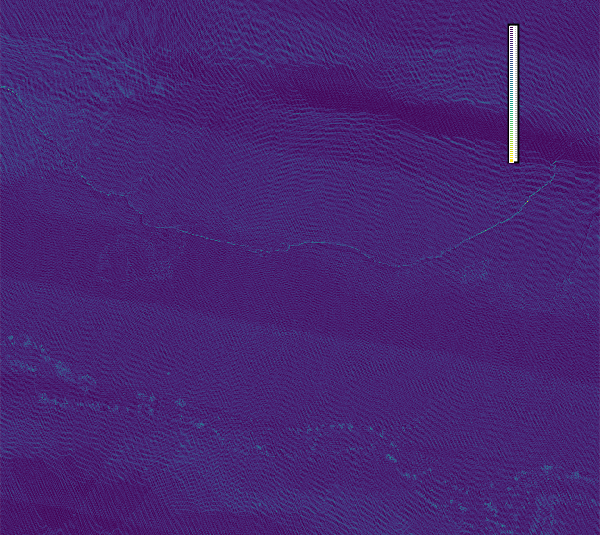

In [24]:
m = gj.Map()
m.d_rast(map="points_n")
m.d_vect(map="lidar_boundary", color="red")
m.d_legend(raster="points_n", at=(60, 95, 85, 90), flags="b")
m.show()

In [27]:
gs.run_command('r.in.pdal',
            input='metadata/points.laz', 
            output='points_median',
            method='median', # median of the z values
            resolution=0.5, # meter
            flags="ewn",
            overwrite=True)

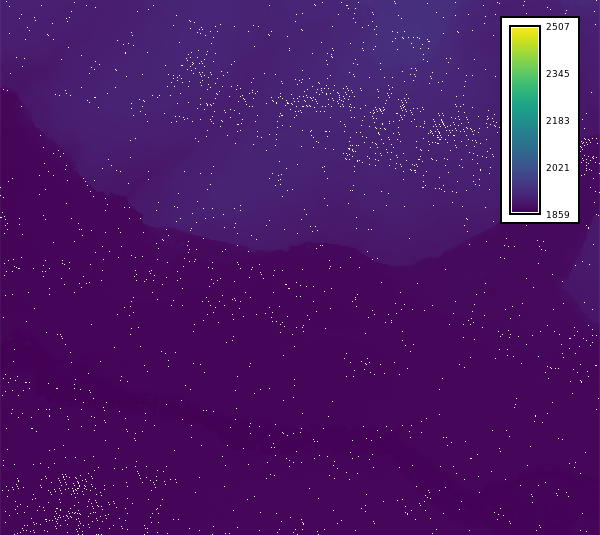

In [28]:
gs.run_command("r.colors", map="points_median", color="elevation", flags="e")
m = gj.Map()

m.d_rast(map="points_median")
m.d_vect(map="lidar_boundary", color="red")
m.d_legend(raster="points_median", at=(60, 95, 85, 90), flags="b")
m.show()

## Import Vector Data

In [ ]:
hist = gj.d_histogram(map="points_median")
hist.show()

In [13]:
gs.run_command("v.import",
               input="https://raw.githubusercontent.com/OpenTopography/Data_Catalog_Spatial_Boundaries/main/OpenTopography_Point_Cloud_Lidar/NM16_Dorshow.geojson",
               output="lidar_boundary", flags="o")

## Visualize the Vector Data

## Perform some preprocessing

In [26]:
gs.run_command('v.in.pdal',
            input='metadata/points.laz', 
            output='lidar_points_be',
            class_filter=2, # Bare earth points
            flags="w",
            overwrite=True)

50 million points.

In [29]:
gs.run_command("v.surf.rst",
               input="lidar_points_be",
               elevation="lidar_be",
               slope="lidar_be_slope",
               aspect="lidar_be_aspect",
               pcurvature="lidar_be_pcurvature",
               tcurvature="lidar_be_tcurvature",
               overwrite=True,
               nprocs=4
            )

## Visualize the Preprocessed Data

In [ ]:
gs.run_command("r.colors", map="lidar_be", color="elevation")
gs.run_command("r.colors", map="lidar_be_slope", color="aspect")
gs.run_command("r.colors", map="lidar_be_aspect", color="aspect")

m = gj.Map()
m.d_rast(map="lidar_be")
m.d_legend(raster="lidar_be", at=(60, 95, 85, 90), flags="b")

## Visualize some univariate statistics and other descriptive statistics

## Run some analysis or model

## Visualize the preliminary results

## Visualize time-series map

## Create figure with pandas and seaborn

## Create Combined Publication Ready Figure

## Export the figure

## Export the data